In [2]:
#-- Module imports
import numpy as np
import matplotlib.pyplot as plt
import os
from sigfig import round

In [3]:
#-- Helper functions
def parse_fname(filename:str):
    fname = os.path.splitext(os.path.basename(filename))[0]
    _, const, _, molecule, unit, decimal = fname.split("_")
    zcount = 2 if int(unit) >= 10 else 3
    molecule, range_type = molecule[:2], molecule[2:]
    decimal, units = decimal[:zcount], decimal[zcount:]
    energy = int(unit) + int(decimal)/(10 ** zcount)
    return (const, molecule, range_type, energy, units)

def get_style(mol, en):
    # style = "--" if mol == "Ge" else "-"
    style="-"
    return style

def plot_file(filename:str):
    data = np.loadtxt(filename)
    const, mol, rtype, en, units = parse_fname(filename)
    plt.xscale("log")
    plt.yscale("log")
    ax = plt.gca()
    if mol == "Xe":
        ax.set_xlim([1e-2, 10])
        ax.set_ylim([1e-36, 1e-17])
    elif mol == "Ge":
        ax.set_xlim([10**(-1.5), 10])
        ax.set_ylim([1e-28, 1e-21])
    plt.xlabel(r"$T \text{(keV)}$") # energy transfer (in keV)
    plt.ylabel(r"$\frac{\text{d}\sigma\vec{v}}{\text{d}T} \text{cm}^3 \text{keV}^{-1} \text{day}^{-1}$") # averaged velocity-weighted differential cross sections (in cm^3/keV/day)
    plt.plot(data[:,0], data[:,1], get_style(mol, en), linewidth=3, label=f"{mol} {en} {units}")

def make_plot(molecule:str, range_type:str, energy:float, exclude:set=None):
    '''
    molecule: Ge or Xe
    range_type: SR or LR
    energy: float
    '''
    molecule = molecule.capitalize()
    range_type = range_type.upper()
    const = "d4" if range_type == "LR" else "c4"
    unit = int(np.floor(energy))
    zcount = 2 if unit >= 10 else 3
    dec = str(int((energy - unit) * 10**zcount))
    # print(unit, dec, zcount, dec.zfill(zcount))
    path = f"data/{molecule}_{const}/data_{const}_avDCS_{molecule}{range_type}_{unit}_{dec.zfill(zcount)}GeV.txt"
    if path in exclude or not os.path.isfile(path):
        return False
    plot_file(path)
    exclude.add(path)
    return True

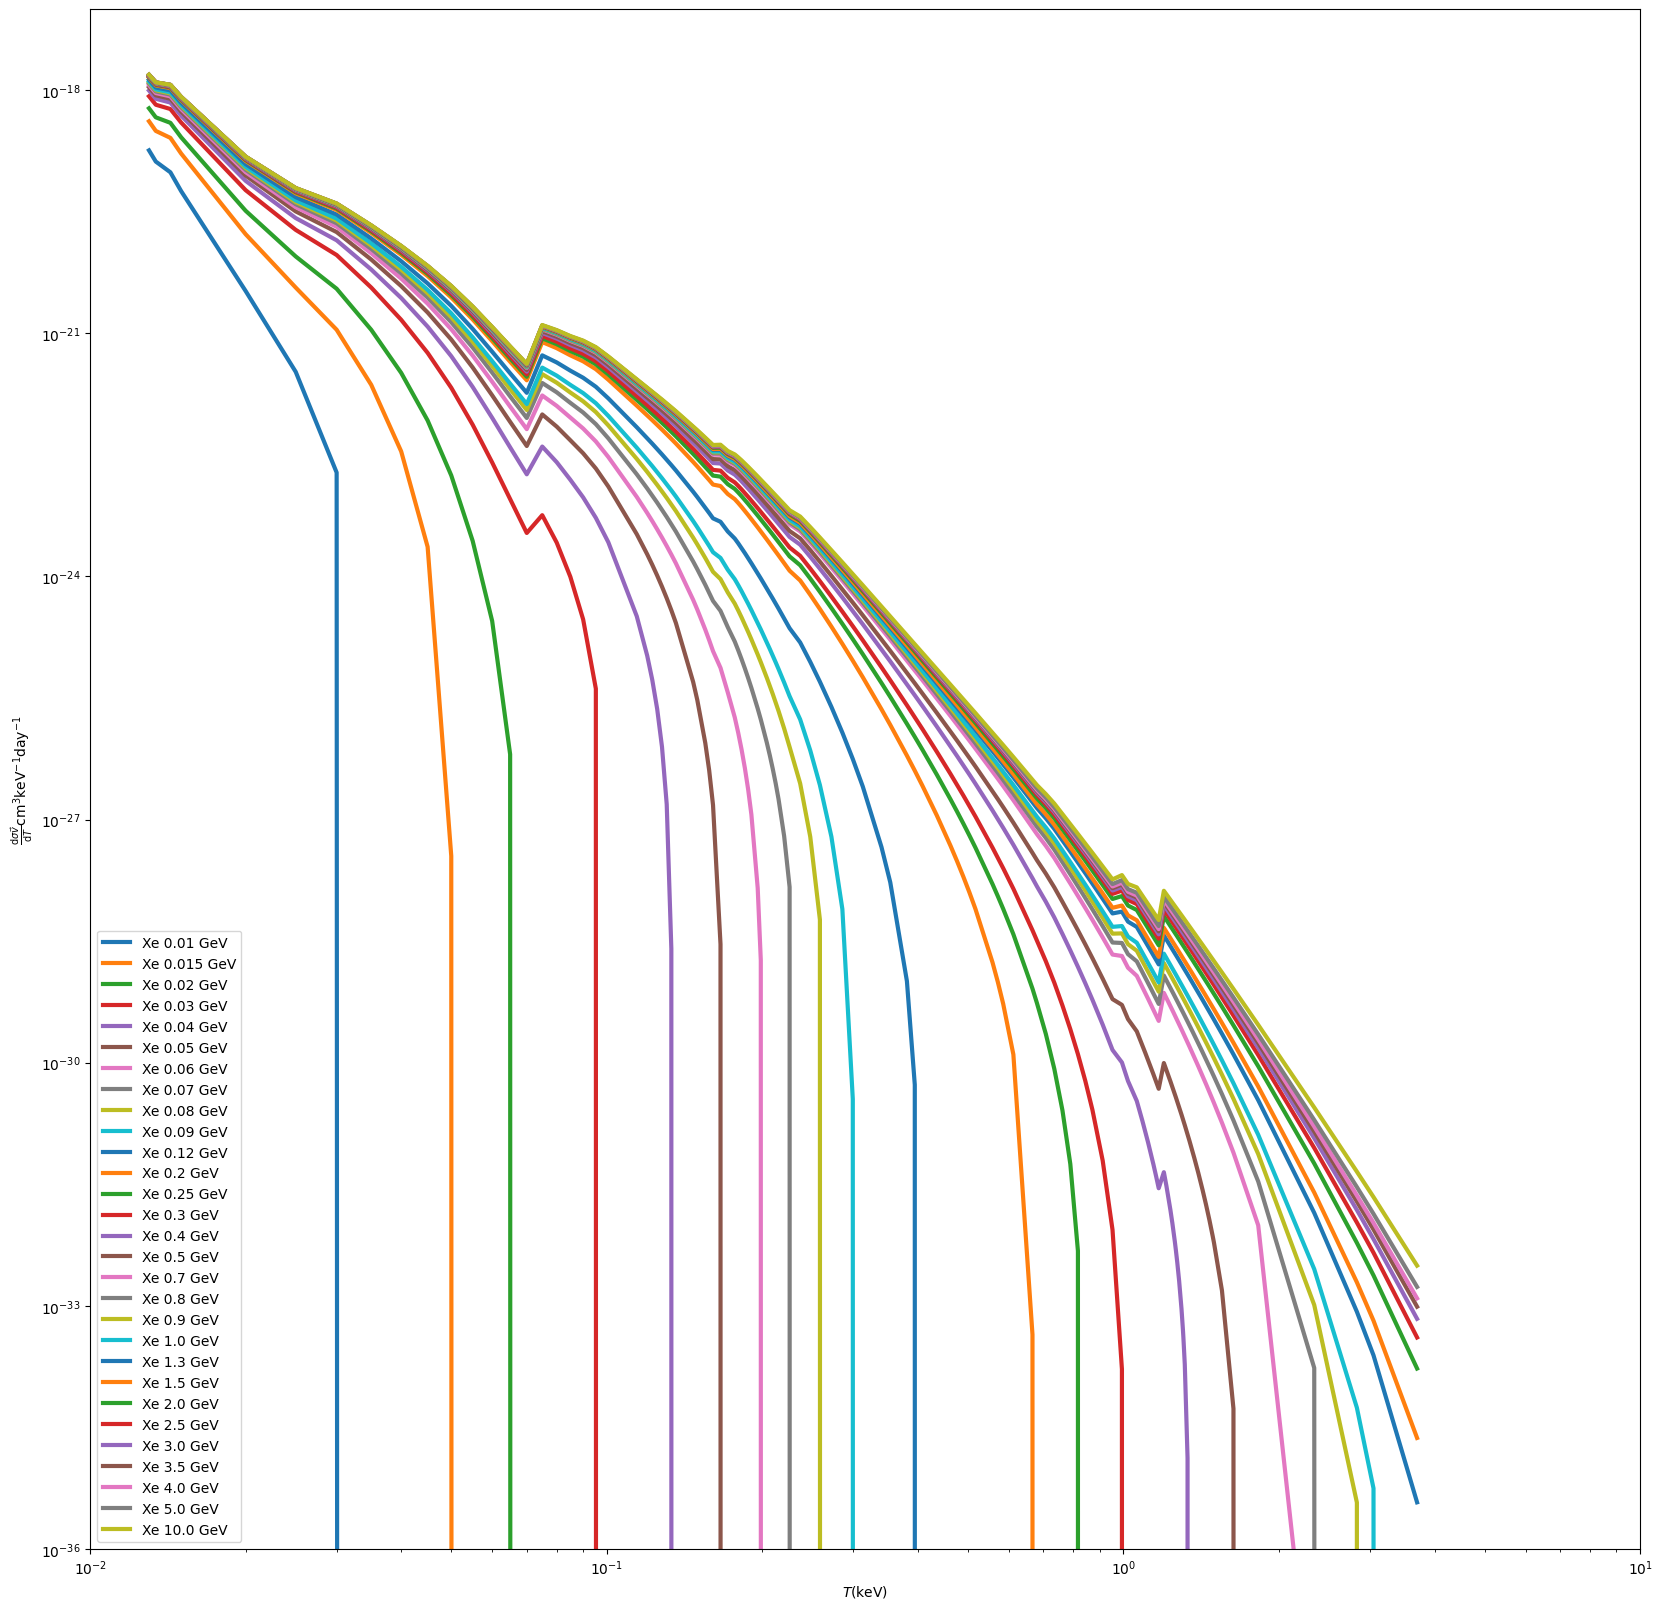

In [4]:
#-- Velocity differential vs energy plot
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
done = set()
for i in range(0, 20000):
    i = i/1000
    made = make_plot("xe", "lr", i, exclude=done)
plt.legend(loc="lower left")
plt.show()

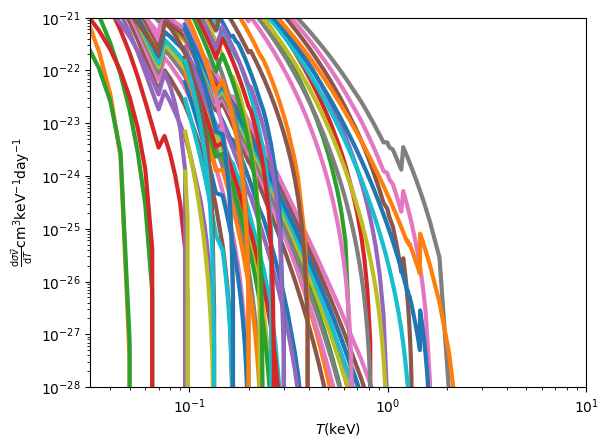

Xe LR Intersect (should be exactly 0): 0.0
Xe LR Gradient: 3.3141583445239413
Ge LR Intersect (should be exactly 0): 0.0
Ge LR Gradient: 3.315499074808353
Xe SR Intersect (should be exactly 0): 0.0
Xe SR Gradient: 3.3141583445239413
Ge SR Intersect (should be exactly 0): 0.0
Ge SR Gradient: 3.315499074808353


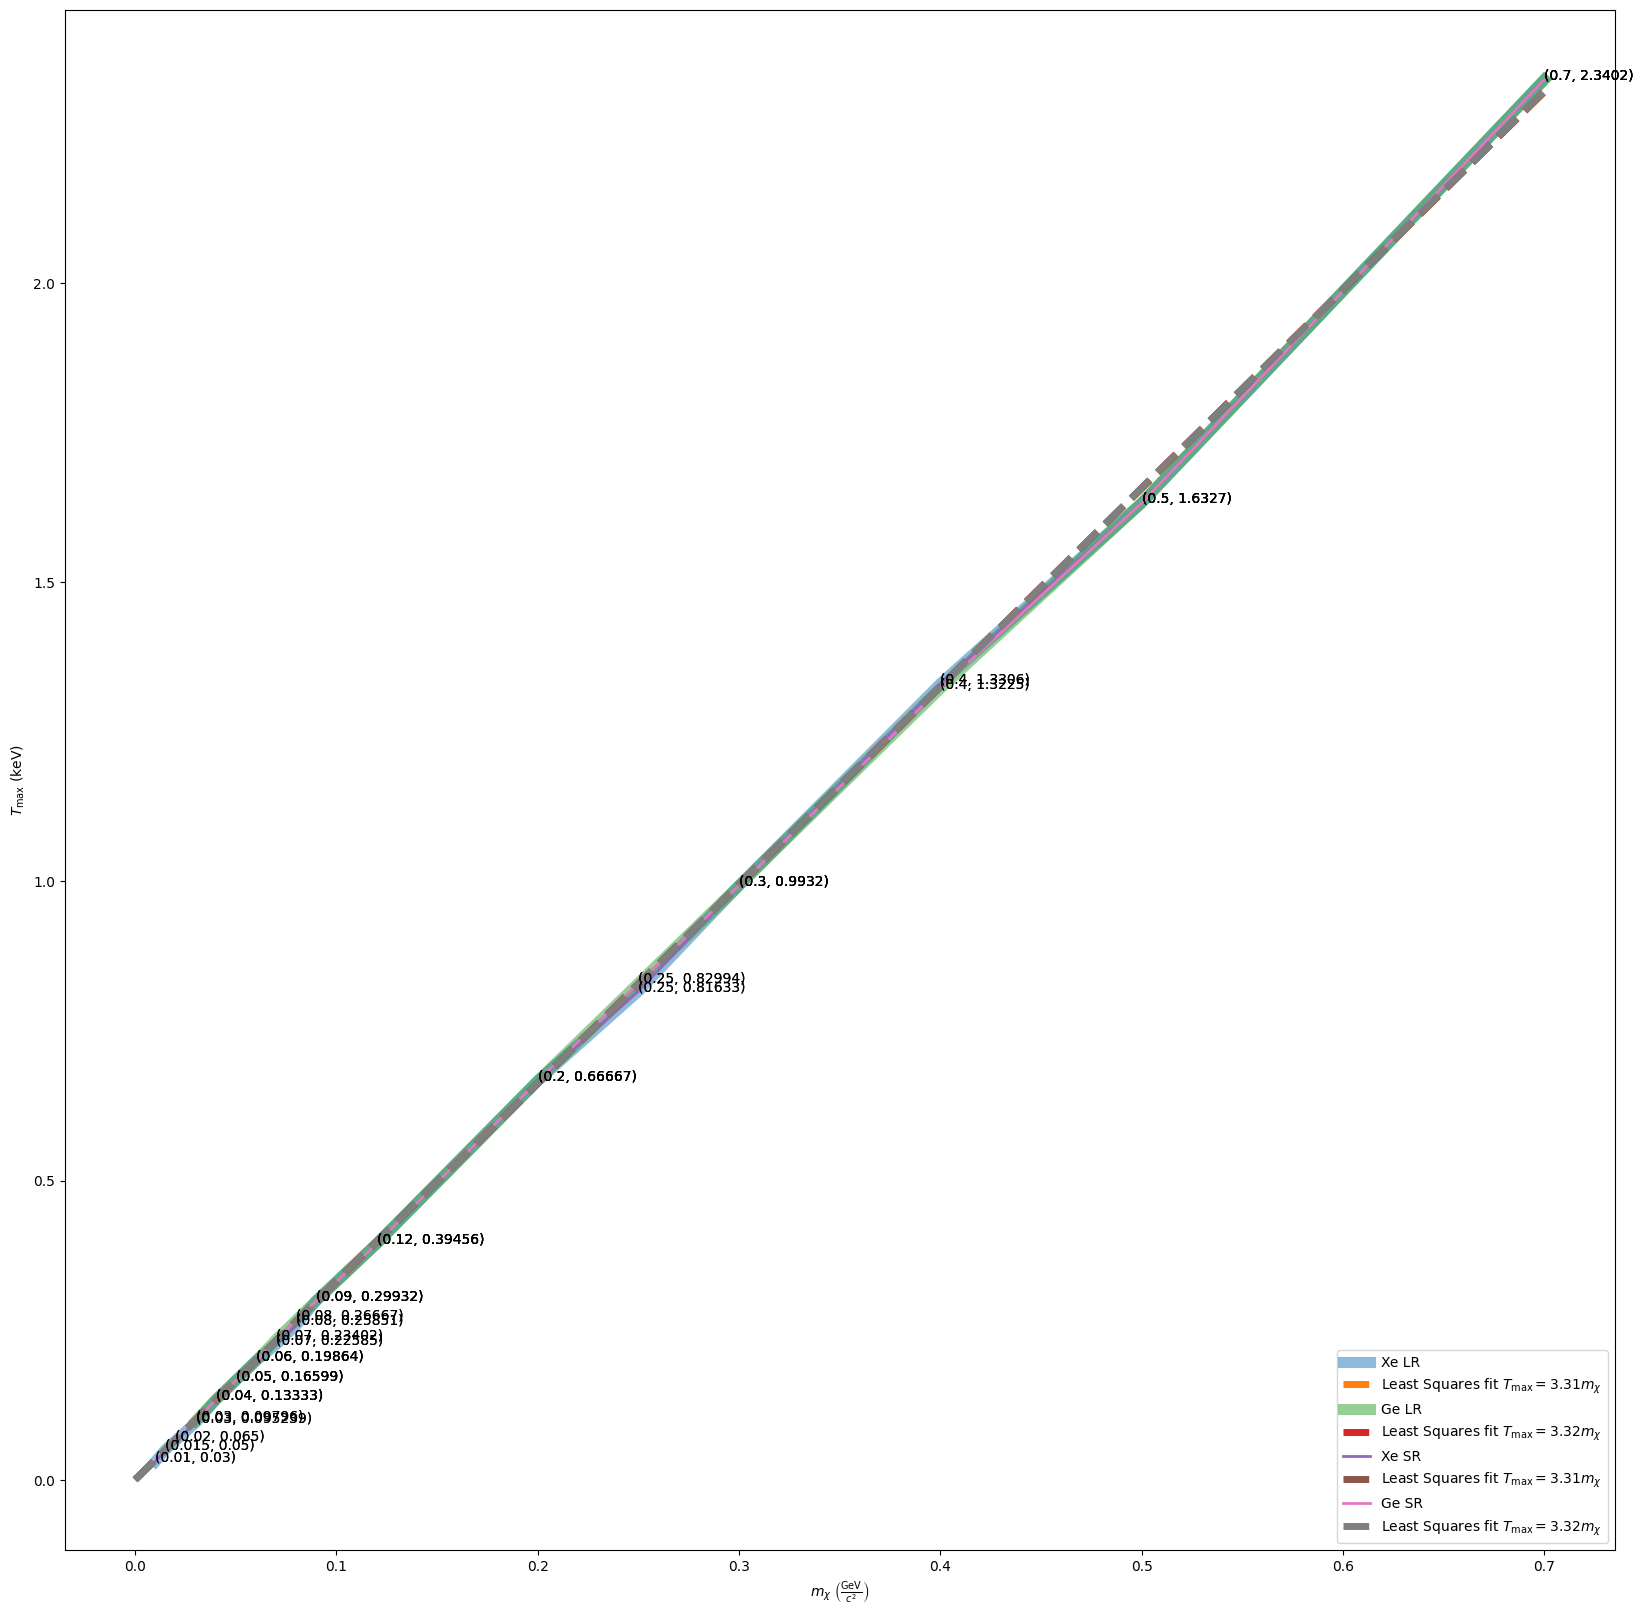

In [5]:
def t_mx(done, lab, mx, lw=1,alph=1):
    #-- Tmax vs mass
    Ts = []
    Masses = []
    names = []
    allofem = list(done)
    broken = []
    for p in done:
        maxT = 0
        arr = np.loadtxt(p)
        # print(arr)
        for x, y in arr:
            if y != 0.0:
                maxT = x
            else:
                broken.append(p)
                break
        _, _, _, en, _ = parse_fname(p)
        Masses.append(en)
        Ts.append(maxT)
        names.append(p)
    
    notbroken = [f for f in allofem if f not in broken]
    # print('\n'.join(notbroken))
    Masses = np.array(Masses, dtype=np.float64)
    Ts = np.array(Ts, dtype=np.float64)
    arr = np.vstack([Masses, Ts]).T
    arr = arr[arr[:, 0].argsort()]
    # print(arr)
    arr = arr[arr[:,1] < mx]
    # print(arr)
    
    A = np.vstack([arr[:,0], np.zeros(len(arr[:,0]))]).T
    m,c = np.linalg.lstsq(A, arr[:,1])[0]
    print(lab, "Intersect (should be exactly 0):", c)
    print(lab, "Gradient:", m)
    
    # plt.xscale("log")
    # plt.yscale("log")
    plt.plot(arr[:,0], arr[:,1], label = lab, linewidth=lw,alpha=alph)
    ax = plt.gca()
    for xy in arr:
        xy = tuple(xy)
        ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    
    x = np.linspace(0, 0.7, 2)
    y = m * x + c
    plt.plot(x, y, '--', alpha=1, linewidth=5, label = r"Least Squares fit $T_{\text{max}} = " + str(round(m,3)) + r"m_{\chi}$")
    return arr

# maxMeV = 20_000
maxMeV = 700
donexelr = set()
for i in range(0, maxMeV+1):
    i = i/1000
    made = make_plot("xe", "lr", i, exclude=donexelr)
donegelr = set()
for i in range(0, maxMeV+1):
    i = i/1000
    made = make_plot("ge", "lr", i, exclude=donegelr)
donexesr = set()
for i in range(0, maxMeV+1):
    i = i/1000
    made = make_plot("xe", "sr", i, exclude=donexesr)
donegesr = set()
for i in range(0, maxMeV+1):
    i = i/1000
    made = make_plot("ge", "sr", i, exclude=donegesr)
plt.show()
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
xelr = t_mx(donexelr, "Xe LR",3.7,8,0.5)
gelr = t_mx(donegelr, "Ge LR",5,8,0.5)
xesr = t_mx(donexesr, "Xe SR",3.7,2)
gesr = t_mx(donegesr,"Ge SR",5,2)
plt.ylabel(r"$T_\text{max}$ (keV)")
plt.xlabel(r"$m_{\chi}$ $\left(\frac{\text{GeV}}{c^2}\right)$")
plt.legend(loc='lower right')
plt.show()
# plt.savefig("out.png")

In [19]:
me = 9.11e-31
vmax = 776_000
ve = -2e6
print("  mx (kg) \t\t Data (keV)\t\t Predicted (keV)")
print("-"*72)
for mx, T_max_pred in gesr:
    mx *= (1.6e-19*1e9)/(3e8**2)
    # T_max_expected = (2 * me * mx**2 * vmax**2)/((me + mx)**2)
    T_max_expected = (2 * me * mx * (vmax - ve) * (me * ve + mx * vmax))/(me + mx)**2
    T_exp_kev = T_max_expected/(1.6e-19*1e3)
    print(" ", round(mx,sigfigs=2), "\t|\t", round(T_max_pred,sigfigs=4),"  \t|\t", round(T_exp_kev,sigfigs=4))

  mx (kg) 		 Data (keV)		 Predicted (keV)
------------------------------------------------------------------------
  5.3e-29 	|	 0.09796   	|	 0.02267
  7.1e-29 	|	 0.1333   	|	 0.02312
  8.9e-29 	|	 0.166   	|	 0.0234
  1.1e-28 	|	 0.1986   	|	 0.02359
  1.2e-28 	|	 0.234   	|	 0.02372
  1.4e-28 	|	 0.2667   	|	 0.02382
  1.6e-28 	|	 0.2993   	|	 0.0239
  2.1e-28 	|	 0.3946   	|	 0.02405
  3.6e-28 	|	 0.6667   	|	 0.02424
  4.4e-28 	|	 0.8299   	|	 0.0243
  5.3e-28 	|	 0.9932   	|	 0.02434
  7.1e-28 	|	 1.323   	|	 0.02439
  8.9e-28 	|	 1.633   	|	 0.02442
  1.2e-27 	|	 2.34   	|	 0.02445
